In [1]:
# Import the libraries

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import pickle
import xgboost

import shap
# https://github.com/slundberg/shap

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from IPython.display import Javascript
from IPython.core.display import HTML

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Use Javascript to avoid the auto-scrolling of IPython

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
# Use HTML to center the .png's

In [6]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [7]:
# Path to raw github data

gral_path = 'https://raw.githubusercontent.com/jrsamuellopez/purchasing-power-and-burden-of-illness/master/Data/'
gral_path = 'Data/'

In [8]:
# LOAD THE DATA

# Load target names
df_accuracy = pd.read_csv(gral_path+'test_accuracy.csv')

df_accuracy_regression = pd.read_csv(gral_path+'regression_test_accuracy.csv')

big_list_all_cause = list(df_accuracy['cause'].values)
cost_types = big_list_all_cause[:3]
cause_list = big_list_all_cause[3:]

# Load expenditure
expenditure = pd.read_csv(gral_path+'expenditure.csv')
expenditure['2015 expenditure per capita USD'] = expenditure['2015 expenditure per capita USD'].astype(float)

# Load list of top diseases
Top_diseases = pd.read_csv(gral_path+'Top_diseases.csv')
top_diseases_list = list(Top_diseases['cause'].values)

# Load predictors matrix
X1 = pd.read_csv(gral_path+'X_predictors.csv')
all_countries = X1['Country'].unique()

In [9]:
# CREATE WIDGETS

temp_list = []
temp_list.append('------')
dropdown_causes = widgets.Dropdown(options = temp_list+big_list_all_cause)
style = {'description_width': 'initial'}
dropdown_causes_box = widgets.HBox([widgets.Label('Disease or cost', style=style), dropdown_causes])
output_causes = widgets.Output()

dropdown_shap_features = widgets.Dropdown(options = [], description = 'Product:')
output_shap = widgets.Output()

# Choose city (drop menu here) - USER
dropdown_countries = widgets.Dropdown(options = temp_list+sorted(all_countries), description = 'Country:')

selected_country = dropdown_countries.value
all_cities = X1.loc[X1['Country'] == selected_country]['Country_city'].unique()
dropdown_cities = widgets.Dropdown(options = temp_list+sorted(all_cities), description = 'City:')
output_cities = widgets.Output()

reset_values = widgets.Button(description="Reset default values")

run_estimation = widgets.Button(description="Run estimation")
run_estimation.style.button_color = 'lightgreen'
output_estimation = widgets.Output()

dropdown_diseases = widgets.Dropdown(options = ['Only selected disease', 'Top 20 diseases by cost', 'All 169 diseases'],
                                    description = 'City analysis:')

In [10]:
# GENERAL FUNCTIONS

In [11]:
# Plotting function used to put number next to barplots

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() 
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - 0.3
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [12]:
# FUNCTIONS TO HANDLE EVENTS

In [13]:
# Plot the SHAP values of a given disease or cost, and get the top 10 features with the highest absolute SHAP values

def dropdown_causes_eventhandler(change):
    
    global shap_values
    global X_for_shape_dep
    global X_for_shape_dep_power
    global highest_shap_features
    global X_city_names
    global X_zcore
    global means
    global stds
    global cause
    
    output_estimation.clear_output()
    output_causes.clear_output()
    with output_causes:

        #clear_output(wait=True)
        cause = dropdown_causes.value
        
        if cause != '------':
        
            #print(df_accuracy.loc[df_accuracy['cause'] == cause])
            corr = np.round(df_accuracy.loc[df_accuracy['cause'] == cause]['correlation'].values[0], 3)            
            print("Selected disease or cost: {0}".format(str.capitalize(cause)))
            print("Correlation of model prediction with actual test data: {0}".format(corr))

            # Load SHAP values
            url = gral_path+cause+' SHAP.csv'
            #df_shap_values = pd.read_csv(url.replace(' ', '%20'))
            df_shap_values = pd.read_csv(gral_path+cause+' SHAP.csv')
            shap_values = df_shap_values.to_numpy()

            # Choose the top highest SHAP values to modify them
            highest_shap_features = df_shap_values.abs().mean().sort_values(ascending=False).index

            # Load predictors
            X = pd.read_csv(gral_path+'X_predictors.csv')
            X = X[X[cause].notnull()]

            # Get the original data
            X_city_names = X.copy()

            X_col = list(X_city_names.columns)
            X_col.remove('Country')
            X_col.remove('Year')
            X_col.remove('Country_city')
            X_col.remove('City')
            X_col.remove('Population')

            for i in cost_types:
                X_col.remove(i)

            for i in cost_types:
                X_col.remove(i+' times population')

            for i in cause_list:
                X_col.remove(i)

            means = X[X_col].mean()
            stds = X[X_col].std()
            X_zcore = (X[X_col] - means)/stds

            factor_temp_all = X['Average Monthly Net Salary (After Tax)'].values

            # USER CAN DEFINED THE NUMBER OF FEATURES (DEFAULT = 10)
            shap.summary_plot(shap_values, X_zcore, plot_size = (12, 10),  max_display=10)

            dropdown_shap_features.options = temp_list+list(highest_shap_features)
            
            X_for_shape_dep_power = X[X_col].copy()
            X_for_shape_dep = X[X_col].copy()
            X_for_shape_dep[X_col[:-1]] = X_for_shape_dep[X_col[:-1]].copy().multiply(factor_temp_all, axis='rows')
        
    dropdown_cities_eventhandler(True)


In [14]:
# Plot the dependence SHAP plot of each feature (out of the top 10 features)

def dropdown_shap_features_eventhandler(change):
    
    output_shap.clear_output()
    with output_shap:
        if dropdown_shap_features.value != '------':
            if (shap_values.shape == X_for_shape_dep.shape):
                print("SHAP values as a function of the cost/salary")
                f, axes = plt.subplots(figsize=(10, 5))
                shap.dependence_plot(dropdown_shap_features.value, shap_values, X_for_shape_dep_power, 
                                     ax=axes, interaction_index="Average Monthly Net Salary (After Tax)")
                print("SHAP values as a function of the cost (USD)")
                f, axes = plt.subplots(figsize=(10, 5))
                shap.dependence_plot(dropdown_shap_features.value, shap_values, X_for_shape_dep, 
                                     ax=axes, interaction_index="Average Monthly Net Salary (After Tax)")


In [15]:
# Get the cities of the selected country

def dropdown_countries_eventhandler(change):
    
    selected_country = dropdown_countries.value
    dropdown_cities.options = sorted(X1.loc[X1['Country'] == selected_country]['Country_city'].unique())
    output_estimation.clear_output()

In [16]:
# Get the values of the top 10 features (based on their absolute SHAP score) and show to the user for possible manipulation
# of the selected city

def dropdown_cities_eventhandler(change):
    
    global original_vector_z_score
    global user_vector
    global idx
    global population_of_the_city
    global ratio_expenses
    global chosen_city
    global feature_0
    global feature_1
    global feature_2
    global feature_3
    global feature_4
    global feature_5
    global feature_6
    global feature_7
    global feature_8
    global feature_9
    global factor_temp
    
    output_cities.clear_output()
    with output_cities:
    
        chosen_city = dropdown_cities.value
        if X_city_names[(X_city_names['Year'] == 2019) & (X_city_names['Country_city'] == chosen_city)].shape[0]:
        
            idx = X_city_names[(X_city_names['Year'] == 2019) & (X_city_names['Country_city'] == chosen_city)].index[0]

            # Get the data of the city
            original_vector_z_score = X_zcore.loc[[idx,]]
            population_of_the_city = X_city_names[X_city_names['Country_city'] == chosen_city]['Population'].max()/100000

            # Get the country and the rate of expenditure
            korea_expenses = expenditure.loc[expenditure['Country'] == 'SOUTH KOREA', '2015 expenditure per capita USD'].values.astype(float)
            country_expenses = expenditure.loc[expenditure['Country'] == X_city_names.loc[idx, 'Country'], '2015 expenditure per capita USD'].values.astype(float)
            ratio_expenses = country_expenses/korea_expenses

            # Vector to show
            original_vector = original_vector_z_score*stds + means
            factor_temp = original_vector['Average Monthly Net Salary (After Tax)'].values[0]
            original_vector = original_vector*factor_temp
            original_vector['Average Monthly Net Salary (After Tax)'] = original_vector['Average Monthly Net Salary (After Tax)']/factor_temp
            original_vector[highest_shap_features[:10]]

            # USER SELECTS THE VALUE FOR EACH CATEGORY
            user_vector = original_vector

            style = {'description_width': 'initial'}

            feature_0 = widgets.FloatSlider(
                value=user_vector[highest_shap_features[0]].values[0],
                min=0,
                max=user_vector[highest_shap_features[0]].values[0]*4,
                step=user_vector[highest_shap_features[0]].values[0]*0.05,
            )
            box_feature_0 = widgets.HBox([widgets.Label(highest_shap_features[0], style=style), feature_0])

            feature_1 = widgets.FloatSlider(
                value=user_vector[highest_shap_features[1]].values[0],
                min=0,
                max=user_vector[highest_shap_features[1]].values[0]*4,
                step=user_vector[highest_shap_features[1]].values[0]*0.05,
            )
            box_feature_1 = widgets.HBox([widgets.Label(highest_shap_features[1], style=style), feature_1])

            feature_2 = widgets.FloatSlider(
                value=user_vector[highest_shap_features[2]].values[0],
                min=0,
                max=user_vector[highest_shap_features[2]].values[0]*4,
                step=user_vector[highest_shap_features[2]].values[0]*0.05,
            )
            box_feature_2 = widgets.HBox([widgets.Label(highest_shap_features[2], style=style), feature_2])

            feature_3 = widgets.FloatSlider(
                value=user_vector[highest_shap_features[3]].values[0],
                min=0,
                max=user_vector[highest_shap_features[3]].values[0]*4,
                step=user_vector[highest_shap_features[3]].values[0]*0.05,
            )
            box_feature_3 = widgets.HBox([widgets.Label(highest_shap_features[3], style=style), feature_3])

            feature_4 = widgets.FloatSlider(
                value=user_vector[highest_shap_features[4]].values[0],
                min=0,
                max=user_vector[highest_shap_features[4]].values[0]*4,
                step=user_vector[highest_shap_features[4]].values[0]*0.05,
            )
            box_feature_4 = widgets.HBox([widgets.Label(highest_shap_features[4], style=style), feature_4])

            feature_5 = widgets.FloatSlider(
                value=user_vector[highest_shap_features[5]].values[0],
                min=0,
                max=user_vector[highest_shap_features[5]].values[0]*4,
                step=user_vector[highest_shap_features[5]].values[0]*0.05,
            )
            box_feature_5 = widgets.HBox([widgets.Label(highest_shap_features[5], style=style), feature_5])

            feature_6 = widgets.FloatSlider(
                value=user_vector[highest_shap_features[6]].values[0],
                min=0,
                max=user_vector[highest_shap_features[6]].values[0]*4,
                step=user_vector[highest_shap_features[6]].values[0]*0.05,
            )
            box_feature_6 = widgets.HBox([widgets.Label(highest_shap_features[6], style=style), feature_6])

            feature_7 = widgets.FloatSlider(
                value=user_vector[highest_shap_features[7]].values[0],
                min=0,
                max=user_vector[highest_shap_features[7]].values[0]*4,
                step=user_vector[highest_shap_features[7]].values[0]*0.05,
            )
            box_feature_7 = widgets.HBox([widgets.Label(highest_shap_features[7], style=style), feature_7])

            feature_8 = widgets.FloatSlider(
                value=user_vector[highest_shap_features[8]].values[0],
                min=0,
                max=user_vector[highest_shap_features[8]].values[0]*4,
                step=user_vector[highest_shap_features[8]].values[0]*0.05,
            )
            box_feature_8 = widgets.HBox([widgets.Label(highest_shap_features[8], style=style), feature_8])

            feature_9 = widgets.FloatSlider(
                value=user_vector[highest_shap_features[9]].values[0],
                min=0,
                max=user_vector[highest_shap_features[9]].values[0]*4,
                step=user_vector[highest_shap_features[9]].values[0]*0.05,
            )
            box_feature_9 = widgets.HBox([widgets.Label(highest_shap_features[9], style=style), feature_9])

            print('COST (USD) IN 2019')

            display(box_feature_0, 
                   box_feature_1,
                   box_feature_2,
                   box_feature_3,
                   box_feature_4,
                   box_feature_5,
                   box_feature_6,
                   box_feature_7,
                   box_feature_8,
                   box_feature_9)

        else:
            print("There is not enough data for this city")
        display(reset_values)
        display(run_estimation)


In [17]:
# Reset the values of the city features

def reset_values_eventhandler(change):
    with output_cities:
        dropdown_cities_eventhandler(True)

In [18]:
# Estimate the cost and diseases with the user values and plot them for comparison purposes

def run_estimation_eventhandler(change):
    output_estimation.clear_output()
    with output_estimation:
        
        
        new_user_vector = user_vector.copy()
        new_user_vector[highest_shap_features[0]] = feature_0.value
        new_user_vector[highest_shap_features[1]] = feature_1.value
        new_user_vector[highest_shap_features[2]] = feature_2.value
        new_user_vector[highest_shap_features[3]] = feature_3.value
        new_user_vector[highest_shap_features[4]] = feature_4.value
        new_user_vector[highest_shap_features[5]] = feature_5.value
        new_user_vector[highest_shap_features[6]] = feature_6.value
        new_user_vector[highest_shap_features[7]] = feature_7.value
        new_user_vector[highest_shap_features[8]] = feature_8.value
        new_user_vector[highest_shap_features[9]] = feature_9.value

        new_user_vector['Average Monthly Net Salary (After Tax)'] = new_user_vector['Average Monthly Net Salary (After Tax)']*factor_temp
        new_user_vector = new_user_vector/factor_temp
        new_user_vector = (new_user_vector - means)/stds

        
        

        if dropdown_diseases.value == 'Only selected disease':
            if cause not in cost_types:
                selected_list = cost_types[1:]
                selected_list.append(cause)
            else:
                selected_list = cost_types[1:]   
        if dropdown_diseases.value == 'Top 20 diseases by cost':
            selected_list = cost_types[1:] + top_diseases_list
        if dropdown_diseases.value == 'All 169 diseases':
            selected_list = big_list_all_cause[1:]

        # TOTAL COSTS, DIRECT COST AND INDIRECT COSTS (THIS ORDER)
        # User select the causes
        for i in selected_list:
            #loaded_model = pickle.load(open(i, 'rb'))
            loaded_model = pickle.load(open('Models/'+i, 'rb'))
            
            model_estimation_value = loaded_model.predict(original_vector_z_score)
            user_value = loaded_model.predict(new_user_vector)
            real_value = X_city_names.loc[idx, i]

            if i not in cost_types:
                real_value = real_value
                model_estimation_value = model_estimation_value
                user_value = user_value
            else:
                real_value = real_value*population_of_the_city*ratio_expenses/1000000
                model_estimation_value = model_estimation_value*population_of_the_city*ratio_expenses/1000000
                user_value = user_value*population_of_the_city*ratio_expenses/1000000


            if i not in cost_types:
                selected_df = pd.DataFrame(np.array([[model_estimation_value[0], 
                                                      user_value[0]]]), 
                                           columns=['Model estimation', 'Estimation after modification'])
            else:
                selected_df = pd.DataFrame(np.array([[model_estimation_value[0], 
                                                  user_value[0]]]), 
                                       columns=['Model estimation', 'Estimation after modification'])
                
            if (not np.isnan(np.max(selected_df.loc[0].values))) and (np.max(selected_df.loc[0].values > 0.1)):
                f, ax = plt.subplots(figsize=(10, 2))    
                sns.set(style="whitegrid")
                sns.set_style("ticks")
                ax = sns.barplot(y=np.array(selected_df.columns), x=selected_df.loc[0].values, orient="h", saturation=.8)
            
                show_values_on_bars(ax, h_v="h", space=np.max(selected_df.loc[0].values)*0.01)

                axes = plt.gca()
                axes.set_xlim([np.min(selected_df.loc[0].values)*0.95,np.max(selected_df.loc[0].values)*1.05])
                ax.grid(False)


                if i not in cost_types:
                    ax.set_title(str.upper(i))
                    ax.set_xlabel('Prevalence per 100,000 inhabitants')
                    percentage_change = (user_value[0]/model_estimation_value[0] - 1)*100
                    print('Change in prevalence of '+str(np.round(percentage_change,2))+'%')
                else:
                    ax.set_title(str.upper(i).replace(" PER CAPITA", ''))
                    ax.set_xlabel('Estimated expenses in '+chosen_city+' (Million USD)')
                    cost_change = model_estimation_value[0] - user_value[0]
                    print('Savings '+str(np.round(cost_change,2))+' USD (Million)')

                plt.show()
            else:
                print('Not enough disease data from this city')


In [19]:
# Call all the events of the widgets to be ready, e.g. when a button is clicked it

dropdown_causes.observe(dropdown_causes_eventhandler, names='value')
dropdown_shap_features.observe(dropdown_shap_features_eventhandler, names='value')
dropdown_countries.observe(dropdown_countries_eventhandler, names='value')
dropdown_cities.observe(dropdown_cities_eventhandler, names='value')
reset_values.on_click(reset_values_eventhandler)
run_estimation.on_click(run_estimation_eventhandler)

In [20]:
# Create 2 dashboards

#box1 = widgets.HBox([dropdown_causes, dropdown_shap_features])
box1 = widgets.HBox([dropdown_causes_box, dropdown_shap_features])
tab1 = widgets.Tab([output_causes, output_shap])
tab1.set_title(0, 'Product costs impact')
tab1.set_title(1, 'Analysis per product')
dashboard1 = widgets.VBox([box1, tab1])

box2 = widgets.HBox([dropdown_countries, dropdown_cities, dropdown_diseases])
tab2 = widgets.Tab([output_cities, output_estimation])
tab2.set_title(0, 'Indicators by city')
tab2.set_title(1, 'Estimation by user')
dashboard2 = widgets.VBox([box2, tab2])

# From here we build the plots, insert the text and display the dashboards...

# The relation between burden of illness and purchasing power in major cities around the world

By Junior Samuel López-Yépez (August/2020)

<br />

In this project, as a proof of concept, I analyze the prevalence of 169 different diseases and injuries based on how many products of a kind the people can buy in a given city. I also explore the potential costs of the top 20 most expensive diseases and injuries ([Measuring the Economic Burden of Disease and Injury in Korea, 2015](https://jkms.org/DOIx.php?id=10.3346/jkms.2019.34.e80)) and how much money can be saved by modifying the prices of common products in different cities around the world.

The idea of this project was inspired by a case study reported by the World Health Organization (WHO) where they evaluate the impact of [taxes on sugary drinks](https://apps.who.int/iris/handle/10665/260253) on their consumption. In this case study, the WHO reports that "[Evidence shows that a tax on sugary drinks that rises prices by 20% can lead to a reduction in consumption of around 20%, thus preventing obesity and diabetes](https://pubmed.ncbi.nlm.nih.gov/23174017/)". The logic is the next: some products are shown to be nocive for the health, thus, by increasing their price (using taxation for instance) it is expected to lower their consumption. Nevertheless, in this project there is a twist on that logic. I wanted to know the effects of not only one product but many products, around the world, on many diseases and their economic burden. Therefore, instead of analyzing the consumption of certain products, I analyze how easy an average person can buy a given product in a given city and what is its relation with the prevalence of a given disease or injury. Moreover, each disease has an estimated direct cost and an indirect cost, and thus, a change in the prevalence of expensive illness implies a big change in the costs to fight those diseases and injuries.

<br />

## General concepts

**Prevalence:** The prevalence of a disease is the number of people per 100,000 inhabitants that is affected by a given disease or an injury in a given year, in a given region (e.g. a city).

**Direct costs:** The direct health costs of a disease or injury are the medical costs (insured and not insured) and the non-medical costs, such as the transportation and professional caregiving.

**Indirect costs:** The indirect costs of a disease or injury are the productivity losses due to morbidity or premature mortality.

**Total costs:** The sum of the direct and indirect costs.

**Purchasing power:** Wikipedia defines it as "...the amount of goods and services that can be purchased with a unit of currency" (https://en.wikipedia.org/wiki/Purchasing_power). Here, I define it as the perceived price of a product in a given city divided by the average net salary (after tax) of the people living in that city, according to the people themselves. In other words, the currency unit of a city is the average net salary (after tax) in that city.

<br />

## How does this work?

In these interactive dashboards, you can select a disease, injury or directly the cost. Let's say you're particulary interested in how the purchasing power of certain products are related with **Road Injuries**, such as traffic accidents. There are 46 different products (predictors), the list is the next:

* Meal, inexpensive restaurant
* Meal for 2 people, mid-range restaurant, three-course
* Mcmeal at mcdonalds (or equivalent combo meal)
* Domestic beer (0.5 liter draught)
* Imported beer (0.33 liter bottle) in restaurant
* Coke/pepsi (0.33 liter bottle)
* Water (0.33 liter bottle) 
* Cappuccino (regular)
* Milk (regular), (1 liter)
* Loaf of fresh white bread (500g)
* Eggs (regular) (12)
* Water (1.5 liter bottle)
* Domestic beer (0.5 liter bottle)
* Imported beer (0.33 liter bottle)
* Apples (1kg)
* Oranges (1kg)
* Potato (1kg)
* Lettuce (1 head)
* Rice (white), (1kg)
* Tomato (1kg)
* Banana (1kg)
* Onion (1kg)
* Local cheese (1kg)
* Bottle of wine (mid-range)
* Cigarettes 20 pack (marlboro)
* Chicken fillets (1kg)
* Beef round (1kg) (or equivalent back leg red meat)
* Apartment (1 bedroom) in city centre: Rent
* Apartment (1 bedroom) outside of centre: Rent
* Apartment (3 bedrooms) in city centre: Rent
* Apartment (3 bedrooms) outside of centre: Rent
* Price per square meter to buy apartment in city centre
* Price per square meter to buy apartment outside of centre
* One-way ticket (local transport)
* Gasoline (1 liter)
* Monthly pass (regular price)
* Mortgage interest rate in percentages (%), yearly, for 20 years fixed-rate: Multiplied by the price to buy a squared meter in city center
* Basic (electricity, heating, cooling, water, garbage) for 85m2 apartment
* Internet (60 mbps or more, unlimited data, cable/adsl)
* Fitness club, monthly fee for 1 adult
* Tennis court rent (1 hour on weekend)
* Cinema, international release, 1 seat
* 1 pair of jeans (levis 501 or similar)
* 1 summer dress in a chain store (zara, h&m, ...)
* 1 pair of nike running shoes (mid-range)
* 1 pair of men leather business shoes

It is important to mention that there are diseases that has been directly related with the poverty and income level of a country according to some [research](https://www.who.int/intellectualproperty/submissions/InternationalPolicyNetwork.pdf) done by the WHO. In order to differentiate the purchasing power of a product with the income level of that city, I include as another predictor the *Average Net Salary (After Tax)*. Therefore, by analyzing the predictive value, we could see whether the income of a city is more predominantely related to the prevalence of a certain illness, or if it's the economic accesibility to a certain product in that city. For instance, we could compare two low-income (based on the average salary) cities in different parts of the world that have a similar income, but one of them have cheaper beers. How does the prevalence of diseases or injuries would vary according to this difference in beer prices? While the beer is just an example, I do not constrain the model to pick specific products, and the results shown next are purely in the preference of the algorithm as predictors of the prevalence and costs of different diseases and injuries.

Coming back to our example, by selecting in the dropdown menu the **Road Injuries**, a plot like the next will appear.

![title](Images/SHAP_road_injuries.png)

On the vertical axis of this plot we can see the top 10 most relevant features related to that disease (injury or cost). They are sorted based on their absolute SHAP value, which are basically values that tells the impact of a feature (e.g. a product) on the prediction (e.g. the prevalence of a disease) with respect to a certain baseline value. For a great and more comprehensive explanation on SHAP values including the link for the original paper [click here](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30). The nice thing about the SHAP values is that they can represent the influence of the predictors on model prediction even if their relation is non-linear.

The horizontal axis has the impact of that product, where a positive SHAP value means that the estimatd prevalence of a disease, injury or cost increases and the negative SHAP value means the opposite. The color code goes from red (high value) to blue (low value) of each product. Every dot represents the purchasing power or salary in a given city. For instance, a blue dot in **Imported Beer (0.33 liter bottle)** means that the value of that beer divided by the salary in a given city is low, or in other words, you can buy a lot of beer in that city with an average salary! As you can see low values for different types of beers and wine have a positive SHAP values, which could be interpreted as: **if you can buy a lot of beer or wine with your salary, it is more likely that you have more _Road Injuries_ per capita.**

There are features (products or salary) that can have a high absolute mean of SHAP values, and that the algorithm selects them as the most relevant predictors of a given disease, injury or cost. However, their relation with the disease can be hard to tell. While the relation of the **Road Injuries** with the high purchasing power of beer might make intuitive sense, the gasoline and tomato purchasing power might not. We could select the product and see the analysis of that product, automatically sorted by absolute SHAP values, in something called a "dependence plot", as next:

![Gasoline (1 liter), purchasing power](Images/SHAP_road_injuries_gasoline_PP.png)

Here, again each dot is a city, the horizontal axis of the first figure tells the power purchasing of 1 liter of Gasoline. Note the interesting non-linear effect of the purchasing power of the gasoline when we color code each dot (city) based on their salary. There is a clear trend for low-income cities, the expensive the gasoline gets with respect to the salary, the more estimated road injuries per capita, while in the middle- and high-income cities, the cheaper the gasoline with respect to the salary, the higher the estimated road injuries per capita. While the data does not explain why this effect is happening, it suggested that the power purchasing of Gasoline not too high and not too low has the lowest SHAP value, and thus, the lowest related prevalence of road injuries.

Another interesting example is the price of 1Kg of Tomato.

![Tomato (1Kg), cost in USD dollars](Images/SHAP_road_injuries_tomato_price.png)

This is also a dependence plot but the units are different, in this case the horizontal axis comprises the actual price of 1Kg of tomatoes (in USD dollars). We can see here that a cheaper price of tomatoes predicts a smaller number of road injuries, regardless that there is a difference depending on the salary of each city (we can see three nicely color-coded clusters). It might sound a akward that the easier the access to tomatoes in a city, the less road injuries they might expect.
Well, the funny thing is that, and I quote "The breath alcohol concentrations significantly decreased when AFT (alanine-fortified tomato) was ingested" [(article)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4820955/), meaning that it helps in reducing the alcohol absorption in healthy people. Also, it is also shown [here](https://www.ffhdj.com/index.php/ffhd/article/view/201) that the dietary fibers of some botanical foods (such as tomatoes) absorbs solutions containing ethanol. And well, it is not surprising that road injuries are related with alcohol consumption. I know, it is a big jump from tomatoes to road injuries, but the logic would be the next: easier access to tomatoes, more consumption of tomatoes (assuming they are alanine fortified, of course), then less absorption of alcohol, hence less people driving under alcohol effects, and finally less road injuries. As I said, it is a big jump and many things must be taken into account for a proper conclusion, but at least it makes us create a train of thoughts that could lead in a formal research project, who knows?

And these are only two examples of one type of illness. Here it is a dashboard where you can analyze 172 different illness or costs. Some results I found interesting are the relation of depressive disorders with the access to Internet and milk, neonatal disorders with the price of the cigarretes, diabetes and beer, or ischemic hearth disease and basic utilities (such as the electricity bill).

In [21]:
# Call dashboard 1
display(dashboard1)

In the next dashboard we can play with the price (in USD dollars) of the products in the city we select. We choose the country, then the city and the price of the top 10 common goods for the selected disease, injury or cost will appear. We can then modify these values by following the results from the analysis of the disease in all the cities, following our intuition or using whatever logic we like. After we modify the values (there is a reset button to get the original values again in cas you need it) we can use an already trained model to estimate how the prevalence of an illness would change in that city in comparison with the current estimation. It will also compute the direct and indirect cost and report positive or negative "savings" for the new values. You can choose to show, besides the costs, how is the change on the prevalence of the selected illness, the top 20 most expensive (korean) illness or the whole list of illness by changing the price of the products. 

**Important note:** This analysis is based on the assumption that the common goods predicts the prevalence of diseases, whether this is true or not it is beyond this project.

For more details about the cleaning and model training, please go to the bottom of the page. Otherwise, enjoy this tool!

In [22]:
# Call dashboard 2

display(dashboard2)

## Where does the data come from?

**Prevalence of diseases and injuries:** From the great work of the people working on the [_Global Health Data Exchange_](http://ghdx.healthdata.org/gbd-results-tool). The rate of 169 diseases and injuries per country is selected from 2010 to 2017 included.

**Direct of indirect cost of the top 20 most expensive diseases and injuries:** From the article published [here](https://jkms.org/DOIx.php?id=10.3346/jkms.2019.34.e80). It would be great to have the actual costs per city, however, and to make things simpler, I assume the same cost of the diseases and injuries around the world. This data is from 2015.

**How much each city spends on health:** I use the ratio of the direct and indirect cost of the before-mentioned korean article to compute the cost of each of the 20 diseases and injuries in that article. Then, the cost of each disease is divided by the population with that disease in Korea, having the costs of diseases and injuries per capita. But not all the countries spend the same quantity on health per capita, therefore, I scaled the costs by the expenditure per capita on health of South Korea with respect to the country being evaluated. For example, if the country X spent the half of money on health per capita than Korea, then the costs of the diseases and injuries in X are scaled by half, resulting in the costs of diseases and injuries per capita in a given country. By the way, the expenditure of health per capita by each country (in 2017) is taken from the [The World Bank](https://data.worldbank.org/indicator/SH.XPD.CHEX.PC.CD). This scaled cost of diseases per capita was then multiplied by the [population of each city](https://worldpopulationreview.com/world-cities) (in 2020) to have a rough estimation of the current direct cost, indirect and total cost of the top 20 diseases most expensive illness on each city.

**Power purchasing of common goods:** Through scrapping 877 pages of the website https://www.numbeo.com/cost-of-living/. A website that, by the beginning of August 2020, had more than 6'000,000 of collected prices from more than 500,000 contributors located in more than 9,000 cities. I use the mean of the price of the products, from 2010 to 2019, reported on that website. Moreover, the average net salary (after tax) per city is also collected from there.

## Notes on missing data and generalizations within countries

Where there was a missing value for a product price in a given city on a given year, it was filled with the mean product price in the country. If the product price was not found in any city in the country in any year, then the value is kept as missing. Sadly, the values for all the cities of Venezuela has been removed due to their high volatility and extremely low purchasing power. Missing values for the prevalence of diseases in cities were kept as missing, the difference here is that we cannot assume that certain diseases can happen in all cities due to environmental factors, and thus, it is not generalizable.

## Comparing linear regression with gradient boosted tree prediction accuracy

The models trained to predict the prevalence of diseases, injuries and costs are a linear regression model and a gradient boosted tree (non-linear) algorithm. In both cases the data was randomly divided in two sets, a training set with 80% of the data and a test set with 20% of the data, the latter is used to evaluate the accuracy of the different models through simple Pearson's correlation analysis.

The **linear regression** is trained using the train set which is divided in 4 sets to select the coefficients based on the results from a cross-validation under LASSO regularization.

For the gradient boosted tree model, the "Extreme Gradient Boosting", most commonly known as **XGBoost** algorithm is applied. The XGBoost model uses the train set and it randomly divides it in a smaller train set with 85% of the original train set, and uses the 15% remaining for evaluation purposes. The algorithm applies early stopping at 30 rounds after the root mean squared error (RMSE) is not improving on the evaluation set. 

While both models give good predictions (and they could definetly be improved by hyperparameter optimization or model stacking, for instance) there is a clear advantage towards the prediction of the XGBoost models over the linear regression, as it is shown in the next correlation plot of the prediction of each model with respect to the actual test data. Thus, in this project, the XGBoost model is set as the default model to analyze the products and to estimate the prevalence of diseases, injuries and costs.

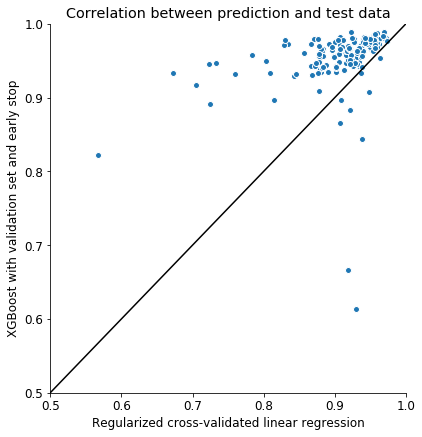

In [23]:
# Plot the test accuracy of the regression and the XGBoost models

plt.rcParams.update({'font.size': 12})

data = pd.DataFrame()
data['XGBoost with validation set and early stop'] = df_accuracy['correlation'].values
data['Regularized cross-validated linear regression'] = df_accuracy_regression['correlation'].values

X_plot = np.linspace(0.5, 1, 100)
Y_plot = X_plot

g = sns.FacetGrid(data, height = 6)
g = g.map(plt.scatter, "Regularized cross-validated linear regression", "XGBoost with validation set and early stop", edgecolor="w")
plt.title('Correlation between prediction and test data')
plt.plot(X_plot, Y_plot, color='k')
plt.xlim(0.5, 1)
plt.ylim(0.5, 1)
plt.show()

### Final notes

Your feedback is always appreciated ([LinkedIn profile](https://www.linkedin.com/in/junior-l%C3%B3pez-79a843194/)). I'd be happy to hear if you find it useful, interesting or just fun to use. Please note that this project is only a proof of concept and its solely purpose is to generate curiosity about the topic by exploring interesting data-driven relations.